# PROJET #2 - Using earlier time zone stock index information to predict stock market direction

## 1. The premise

The premise is straightforward: financial markets are increasingly global, and if you follow the sun from Asia to Europe to the US and so on, **information from an earlier time zone can be used to your advantage in a later time zone**.

The following table shows a number of stock market indices from around the globe, their closing times in Eastern Standard Time (EST), and the delay in hours between the close of that index and the close of the **S&P/TSX Composite Index** in Toronto. This makes EST the base time zone. For example, Australian markets close for the day 15 hours before the Toronto Stock Exchange close. If the close of the All Ords in Australia is a useful predictor of the close of the S&P/TSX Composite Index for a given day we can use that information to guide our trading activity. Continuing our example of the Australian All Ords, if this index closes up and we think that means the S&P/TSX Composite Index will close up as well then we should either buy stocks that compose the S&P/TSX Composite Index or, more likely, an ETF that tracks the S&P/TSX Composite Index. In reality, the situation is more complex because there are commissions and tax to account for. But as a first approximation, we'll assume an index closing up indicates a gain, and vice-versa.

|Index|Country|Closing Time (EST)|Hours Before S&P/TSX CI Close|source|
|---|---|---|---|---|
|[All Ords](https://en.wikipedia.org/wiki/All_Ordinaries)|Australia|0100|15|[yahoo ^AORD](https://ca.finance.yahoo.com/quote/%5EAORD?p=%5EAORD)|
|[Nikkei 225](https://en.wikipedia.org/wiki/Nikkei_225)|Japan|0200|14|[yahoo ^N225](https://finance.yahoo.com/quote/%5EN225/)|
|[Hang Seng](https://en.wikipedia.org/wiki/Hang_Seng_Index)|Hong Kong|0400|12|[yahoo ^HSI](https://finance.yahoo.com/quote/%5EHSI/)|
|[DAX](https://en.wikipedia.org/wiki/DAX)|Germany|1130|4.5|[yahoo ^GDAXI](https://finance.yahoo.com/quote/%5EGDAXI/)|
|[FTSE 100](https://en.wikipedia.org/wiki/FTSE_100_Index)|UK|1130|4.5|[LSE](https://www.londonstockexchange.com/statistics/ftse/ftse.htm)|
|[NYSE Composite](https://en.wikipedia.org/wiki/NYSE_Composite)|US|1600|0|[yahoo ^NYA](https://www.londonstockexchange.com/statistics/ftse/ftse.htm)|
|[Dow Jones Industrial Average](https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average)|US|1600|0|[yahoo ^DJI](https://finance.yahoo.com/quote/%5EDJI/)|
|[S&P 500](https://en.wikipedia.org/wiki/S%26P_500_Index)|US|1600|0|[yahoo ^GSPC](https://ca.finance.yahoo.com/quote/%5EGSPC/)|
|[S&P/TSX Composite Index](https://en.wikipedia.org/wiki/Toronto_Stock_Exchange)|Canada|1600|0|[yahoo ^GSPTSE](https://ca.finance.yahoo.com/quote/%5EGSPTSE?p=^GSPTSE)|

## 2. Set up

First, install and import necessary libraries.

In [1]:
!pip install --upgrade pip
!pip install pandas
!pip install xlrd
!pip install scipy
!pip install sklearn
!pip install seaborn
!pip install openpyxl

In [2]:
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot
from pandas.plotting import scatter_matrix

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(20,15)})

In [3]:
import warnings
warnings.simplefilter('ignore')

## 3. Get the data

The data covers roughly 5 years, using the date range from 31/08/2014 to 37/07/2019. Data comes from the S&P/TSX Composite Index (SNPTSX), S&P 500 (S&P), NYSE, Dow Jones Industrial Average (DJIA), Nikkei 225 (Nikkei), Hang Seng, FTSE 100 (FTSE), DAX, and All Ordinaries (AORD) indices.

#### CSV files

In [4]:
snp = pd.read_csv('^GSPC.csv', index_col='Date', usecols=['Date','Close'], parse_dates=True)
nyse = pd.read_csv('^NYA.csv', index_col='Date', usecols=['Date','Close'], parse_dates=True)
djia = pd.read_csv('^DJI.csv', index_col='Date', usecols=['Date','Close'], parse_dates=True)
nikkei = pd.read_csv('^N225.csv', index_col='Date', usecols=['Date','Close'], parse_dates=True)
hangseng = pd.read_csv('^HSI.csv', index_col='Date', usecols=['Date','Close'], parse_dates=True)
dax = pd.read_csv('^GDAXI.csv', index_col='Date', usecols=['Date','Close'], parse_dates=True)
aord = pd.read_csv('^AORD.csv', index_col='Date', usecols=['Date','Close'], parse_dates=True)
snptsx = pd.read_csv('^GSPTSE.csv', index_col='Date', usecols=['Date','Close'], parse_dates=True)

#### Excel files

In [5]:
ftse = pd.read_excel('FTSE.xlsx', index_col=0, skiprows=16, usecols=['Date','FTSE 100']).sort_index()

## 4. Munge the data

In the first instance, munging the data is straightforward. The closing prices are of interest, so for convenience extract the closing prices for each of the indices into a single Pandas DataFrame, called closing_data. **Because not all of the indices have the same number of values, mainly due to bank holidays, gaps will be forward-filled**. This means that, if a value isn't available for day N, fill it with the value for another day, such as N-1 or N-2, so that it contains the latest available value.

In [6]:
dates = pd.date_range(start='2014-08-31', end='2019-07-31')
closing_data = pd.DataFrame(index=dates)

In [7]:
closing_data = closing_data.join(snp[['Close']].rename(columns={'Close' : 'snp_close'}))
closing_data = closing_data.join(nyse[['Close']].rename(columns={'Close' : 'nyse_close'}))
closing_data = closing_data.join(djia[['Close']].rename(columns={'Close' : 'djia_close'}))
closing_data = closing_data.join(nikkei[['Close']].rename(columns={'Close' : 'nikkei_close'}))
closing_data = closing_data.join(hangseng[['Close']].rename(columns={'Close' : 'hangseng_close'}))
closing_data = closing_data.join(dax[['Close']].rename(columns={'Close' : 'dax_close'}))
closing_data = closing_data.join(aord[['Close']].rename(columns={'Close' : 'aord_close'}))
closing_data = closing_data.join(ftse[['FTSE 100']].rename(columns={'FTSE 100' : 'ftse_close'}))
closing_data = closing_data.join(snptsx[['Close']].rename(columns={'Close' : 'snptsx_close'}))

**All rows having a nan values are dropped. Imputation will be tried in a second research**

In [8]:
closing_data = closing_data.dropna()

At this point, five years of time series for eight financial indices have been sourced, combined the pertinent data into a single data structure, and harmonized the data to have the same number of entries.

In [9]:
del snp, nyse, djia, nikkei, hangseng, dax, aord, ftse, snptsx

In [10]:
closing_data.head()

,snp_close,nyse_close,djia_close,nikkei_close,hangseng_close,dax_close,aord_close,ftse_close,snptsx_close
2014-09-02,2002.280029,11038.120117,17067.560547,15668.599609,24749.019531,9507.019531,5656.899902,6829.174242,15619.099609
2014-09-03,2000.719971,11063.549805,17078.279297,15728.349609,25317.949219,9626.490234,5654.600098,6873.582312,15657.599609
2014-09-04,1997.650024,11030.400391,17069.580078,15676.179688,25297.919922,9724.259766,5632.100098,6877.969681,15576.799805
2014-09-05,2007.709961,11073.410156,17137.359375,15668.679688,25240.150391,9747.019531,5598.899902,6855.098682,15569.900391
2014-09-08,2001.540039,11007.389648,17111.419922,15705.110352,25190.449219,9758.030273,5578.899902,6834.765029,15509.400391


## 5. Exploratory Data Analysis (EDA)

Exploratory Data Analysis (EDA) is foundational to working with machine learning, and any other sort of analysis. EDA means getting to know your data, getting your fingers dirty with your data, feeling it and seeing it. The end result is you know your data very well, so when you build models you build them based on an actual, practical, physical understanding of the data, not assumptions or vaguely held notions. You can still make assumptions of course, but EDA means you will understand your assumptions and why you're making those assumptions. 

First, take a look at the data.

In [11]:
closing_data.describe()

,snp_close,nyse_close,djia_close,nikkei_close,hangseng_close,dax_close,aord_close,ftse_close,snptsx_close
count,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000
mean,2373.907518,11503.694905,20979.312109,19648.417391,25473.625582,11381.122041,5756.989887,6968.175379,15047.566099
std,327.405965,1024.042615,3497.817499,2237.596522,3241.152916,1139.823966,419.425106,493.267851,988.367820
min,1859.329956,9156.839844,15666.440430,14532.509766,18319.580078,8571.950195,4816.600098,5673.580779,11843.099609
25%,2081.625000,10702.054688,17806.512696,17660.585449,23011.814453,10487.142578,5429.474976,6668.489349,14519.375000
50%,2337.875000,11333.364746,20478.830078,19845.290039,25258.074219,11519.830078,5769.900147,7030.153484,15171.350098
75%,2698.000000,12505.824951,24701.924317,21533.697754,28156.000488,12308.990234,6042.974975,7377.631115,15800.975342
max,3025.860107,13524.650391,27335.630859,24270.619141,32966.890625,13559.599609,6928.299805,7788.442838,16669.400391


You can see that the various indices operate on scales differing by orders of magnitude. It's best to scale the data so that, for example, operations involving multiple indices aren't unduly influenced by a single, massive index.

Plot the data.
N.B. A super-useful trick-ette is to assign the return value of plot to _ so that you don't get text printed before the plot itself.

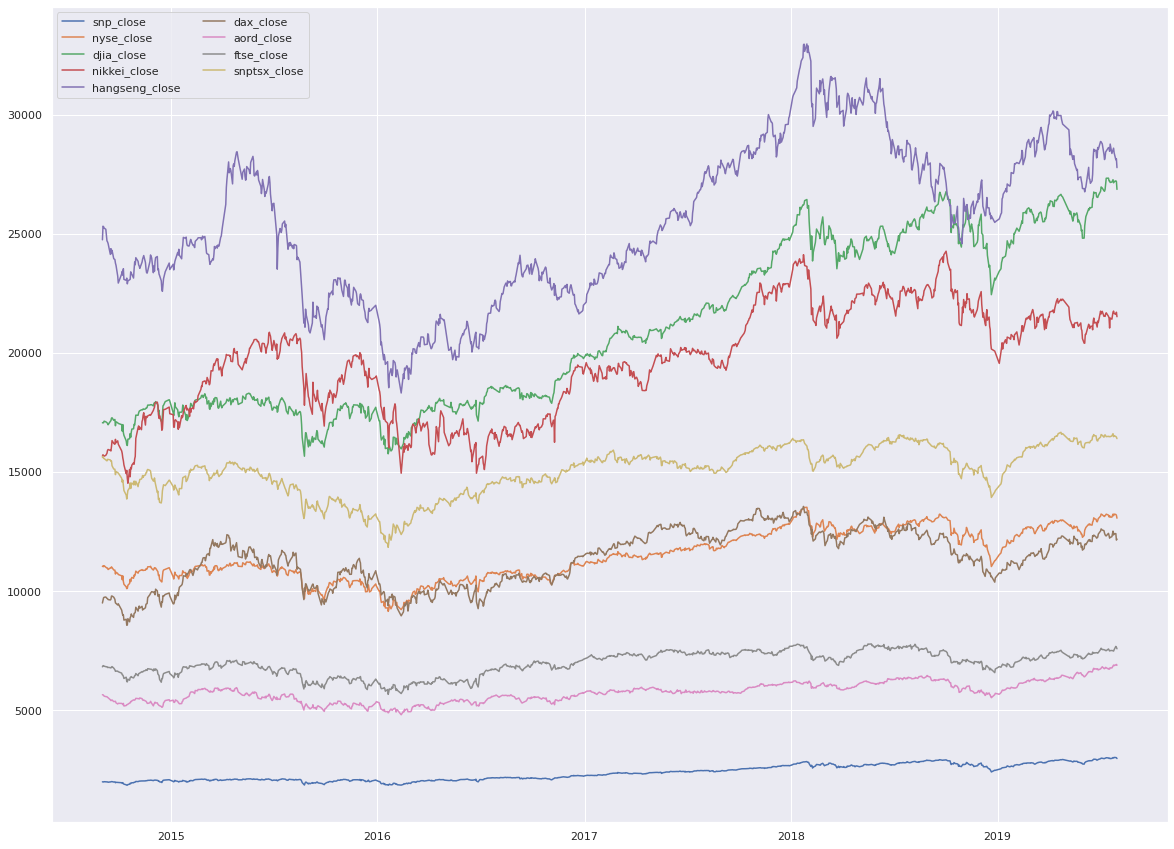

In [12]:
_ = plt.plot(closing_data)
_ = plt.legend(closing_data.columns, ncol=2, loc='upper left');

As expected, the structure isn't uniformly visible for the indices. Divide each value in an individual index by the maximum value for that index., and then replot. The maximum value of all indices will be 1.

In [13]:
closing_data_scaled = closing_data / closing_data.max(axis=0)

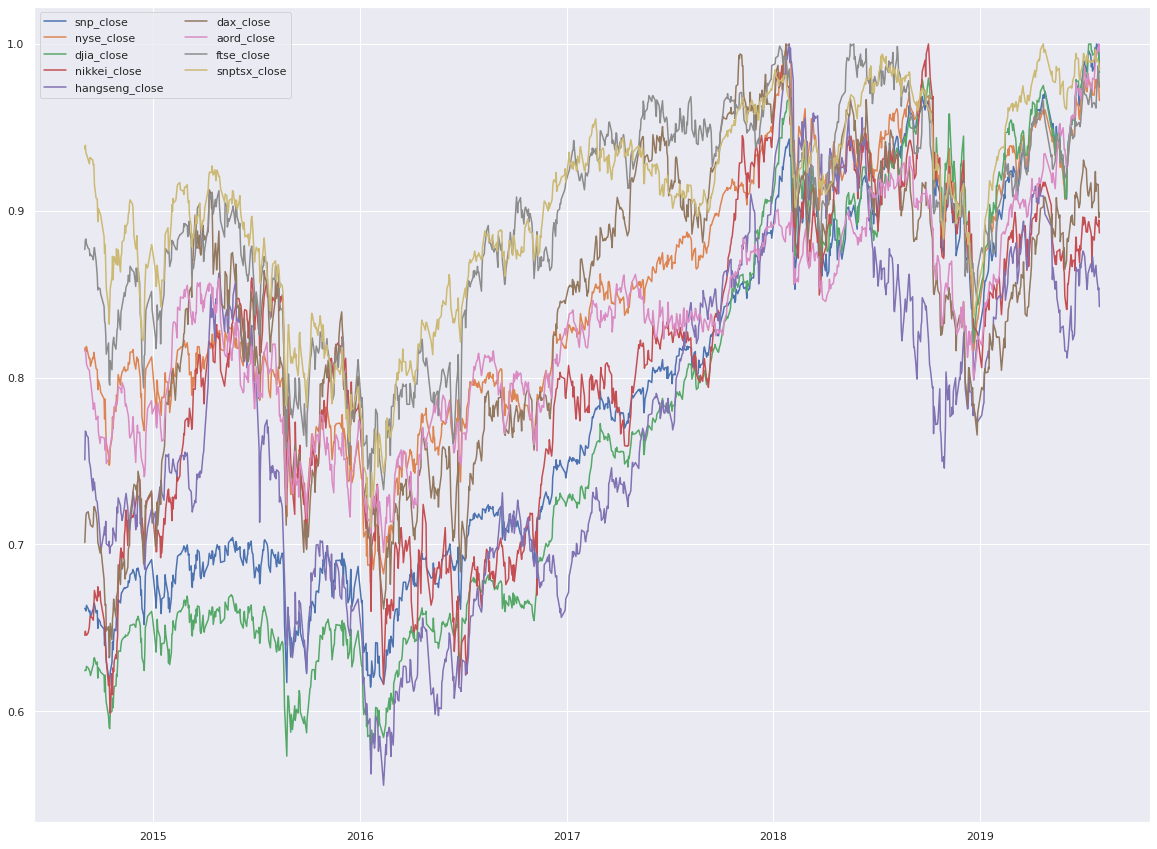

In [14]:
_ = plt.plot(closing_data_scaled)
_ = plt.legend(closing_data_scaled.columns, ncol=2, loc='upper left');

You can see that, over the five-year period, these indices are correlated. Notice that sudden drops from economic events happened globally to all indices, and they otherwise exhibited general rises. This is an good start, though not the complete story. Next, plot autocorrelations for each of the indices. The autocorrelations determine correlations between current values of the index and lagged values of the same index. The goal is to determine whether the lagged values are reliable indicators of the current values. If they are, then we've identified a correlation.

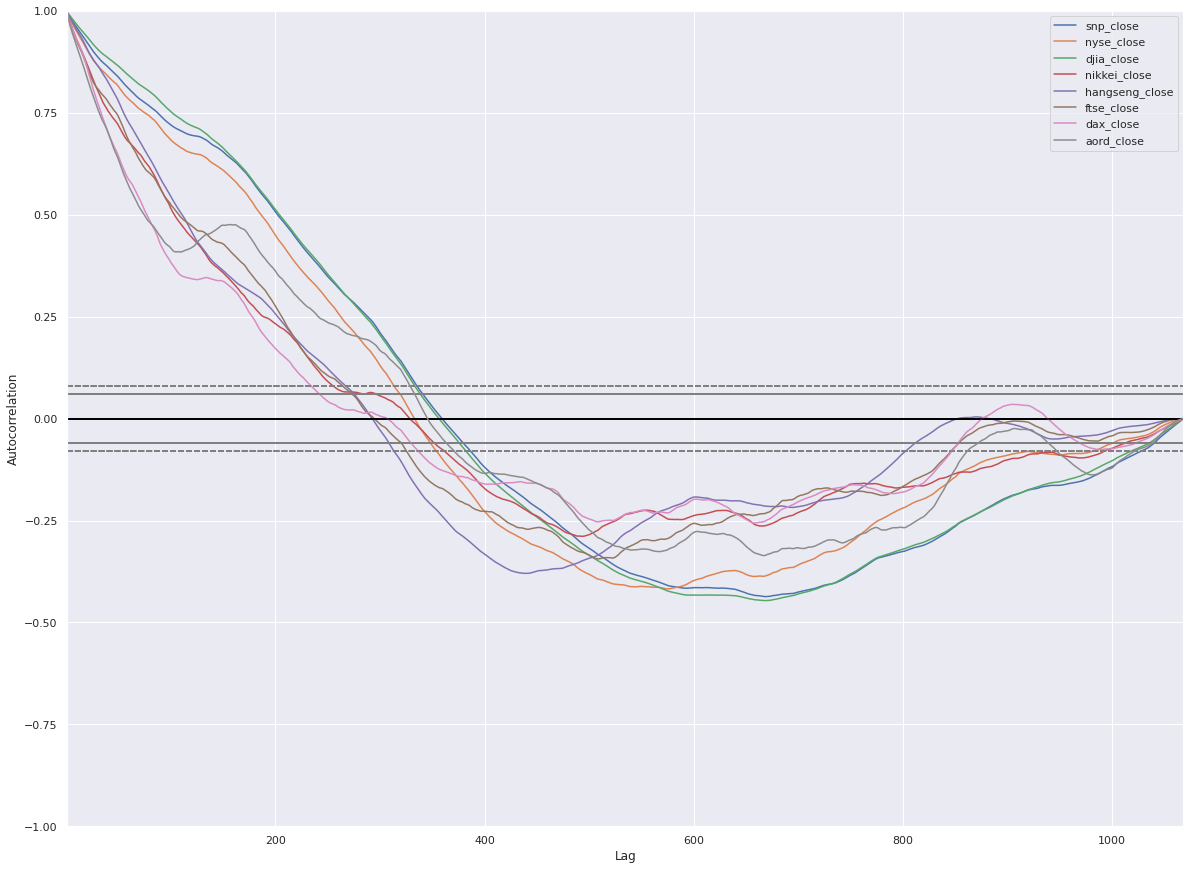

In [15]:
_ = autocorrelation_plot(closing_data['snp_close'], label='snp_close')
_ = autocorrelation_plot(closing_data['nyse_close'], label='nyse_close')
_ = autocorrelation_plot(closing_data['djia_close'], label='djia_close')
_ = autocorrelation_plot(closing_data['nikkei_close'], label='nikkei_close')
_ = autocorrelation_plot(closing_data['hangseng_close'], label='hangseng_close')
_ = autocorrelation_plot(closing_data['ftse_close'], label='ftse_close')
_ = autocorrelation_plot(closing_data['dax_close'], label='dax_close')
_ = autocorrelation_plot(closing_data['aord_close'], label='aord_close')


_ = plt.legend(loc='upper right')

You should see strong autocorrelations, positive for around 300 lagged days, then going negative. This tells us something we should intuitively know: if an index is rising it tends to carry on rising, and vice-versa. It should be encouraging that what we see here conforms to what we know about financial markets.

Next, look at a scatter matrix, showing everything plotted against everything, to see how indices are correlated with each other.

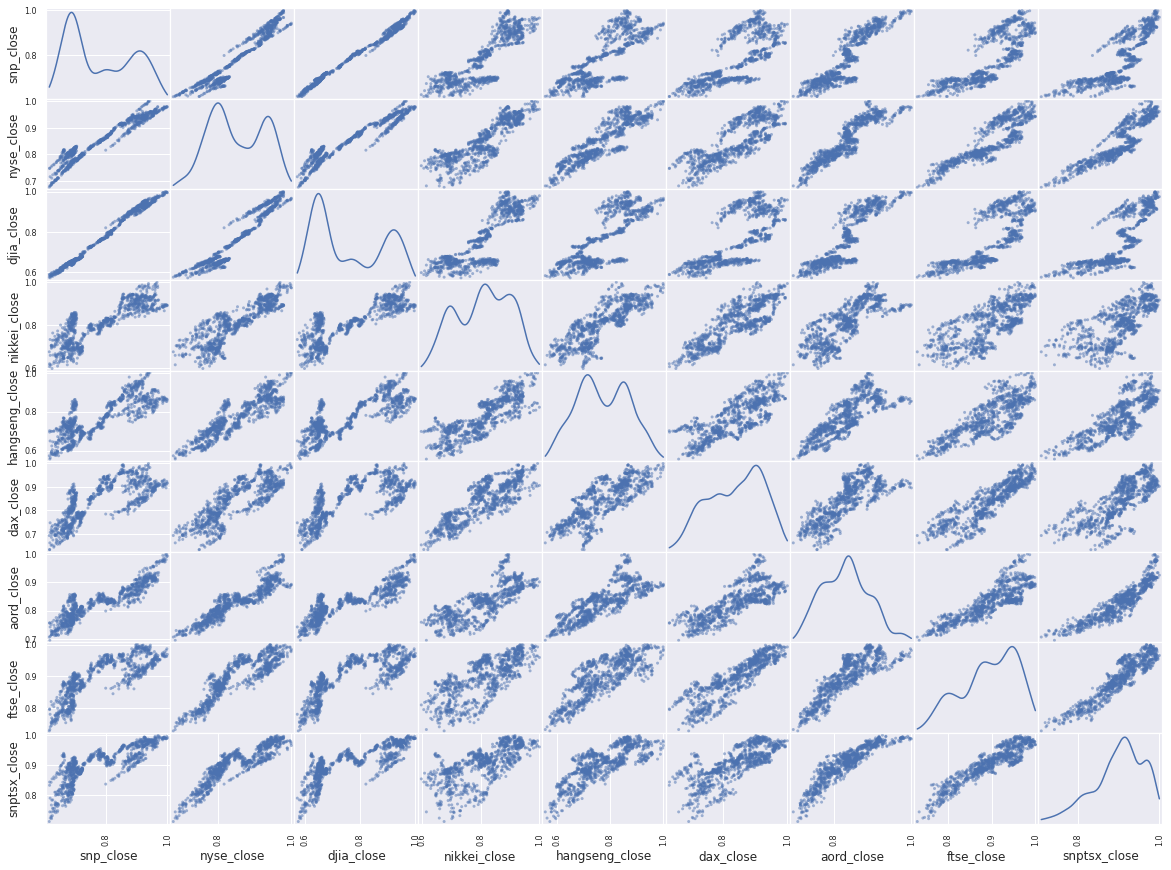

In [16]:
_ = scatter_matrix(closing_data_scaled, diagonal='kde')

You can see significant correlations across the board, further evidence that the premise is workable and one market can be influenced by another. 

As an aside, this process of gradual, incremental experimentation and progress is the best approach and what you probably do normally. With a little patience, we'll get to some deeper understanding.

The actual value of an index is not that useful for modeling. It can be a useful indicator, but to get to the heart of the matter, we need a time series that is stationary in the mean, thus having no trend in the data. There are various ways of doing that, but they all essentially look at the difference between values, rather than the absolute value. In the case of market data, the usual practice is to work with logged returns, calculated as the natural logarithm of the index today divided by the index yesterday:

$$ln(V_t/V_{t-1})$$


There are more reasons why the log return is preferable to the percent return (for example the log is normally distributed and additive), but they don't matter much for this work. What matters is to get to a stationary time series.

Calculate and plot the log returns in a new DataFrame.

In [17]:
log_return_data = np.log(closing_data / closing_data.shift())
log_return_data.columns = ['snp_log_return','nyse_log_return','djia_log_return','nikkei_log_return','hangseng_log_return','dax_log_return','aord_log_return','ftse_log_return','snptsx_log_return']

log_return_data.describe()

,snp_log_return,nyse_log_return,djia_log_return,nikkei_log_return,hangseng_log_return,dax_log_return,aord_log_return,ftse_log_return,snptsx_log_return
count,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000
mean,0.000373,0.000158,0.000425,0.000297,0.000108,0.000233,0.000186,0.000099,0.000046
std,0.008784,0.008427,0.008809,0.013674,0.011833,0.012095,0.008442,0.009397,0.007436
min,-0.041843,-0.043961,-0.047143,-0.117658,-0.061621,-0.070673,-0.042477,-0.047795,-0.031745
25%,-0.003047,-0.003554,-0.003133,-0.005664,-0.006120,-0.005572,-0.004068,-0.004681,-0.003703
50%,0.000509,0.000563,0.000695,0.000761,0.000676,0.000808,0.000619,0.000505,0.000589
75%,0.004976,0.004697,0.004854,0.007165,0.006552,0.006435,0.005019,0.005301,0.004249
max,0.038291,0.029209,0.038755,0.074262,0.042873,0.048521,0.032049,0.037345,0.028963


Looking at the log returns, you should see that the mean, min, max are all similar. You could go further and center the series on zero, scale them, and normalize the standard deviation, but there's no need to do that at this point. Let's move forward with plotting the data, and iterate if necessary.

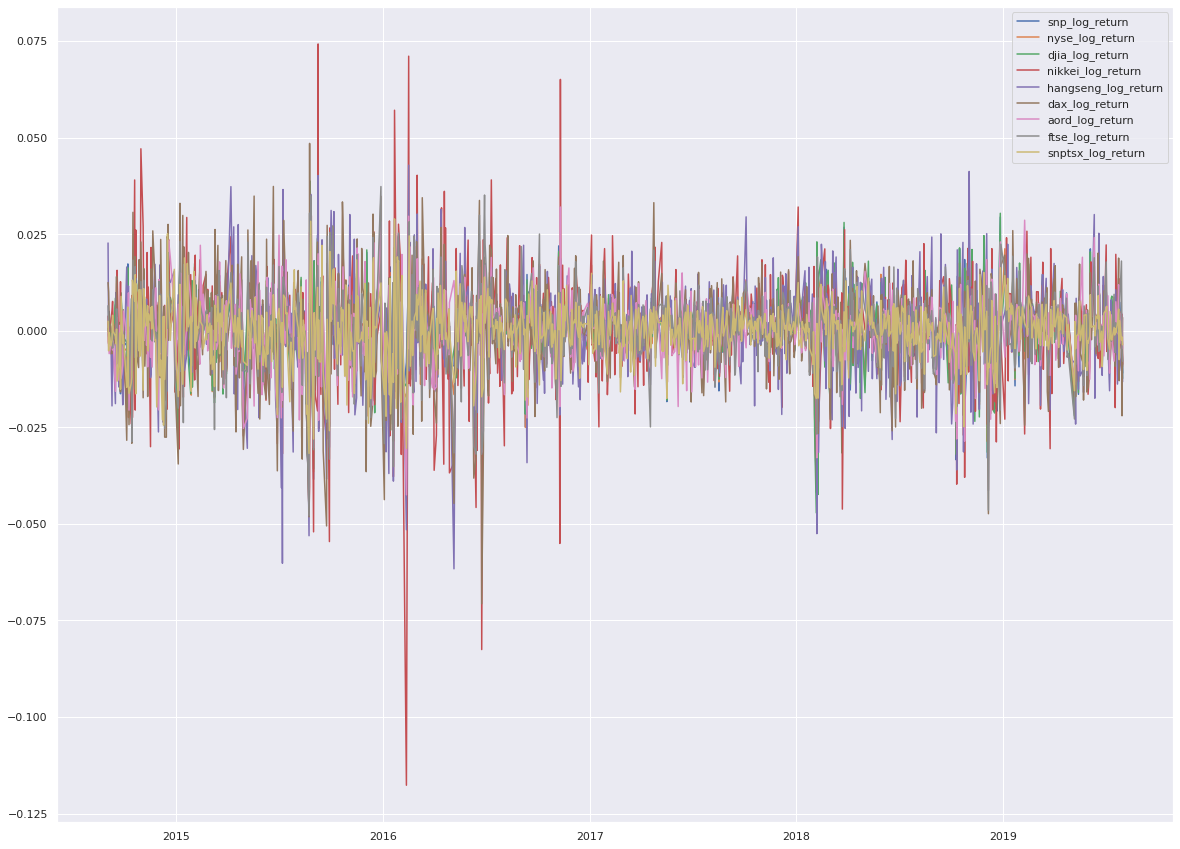

In [18]:
_ = plt.plot(log_return_data)
_ = plt.legend(log_return_data.columns, loc='upper right')

You can see from the plot that the log returns of our indices are similarly scaled and centered, with no visible trend in the data. It's looking good, so now look at autocorrelations.

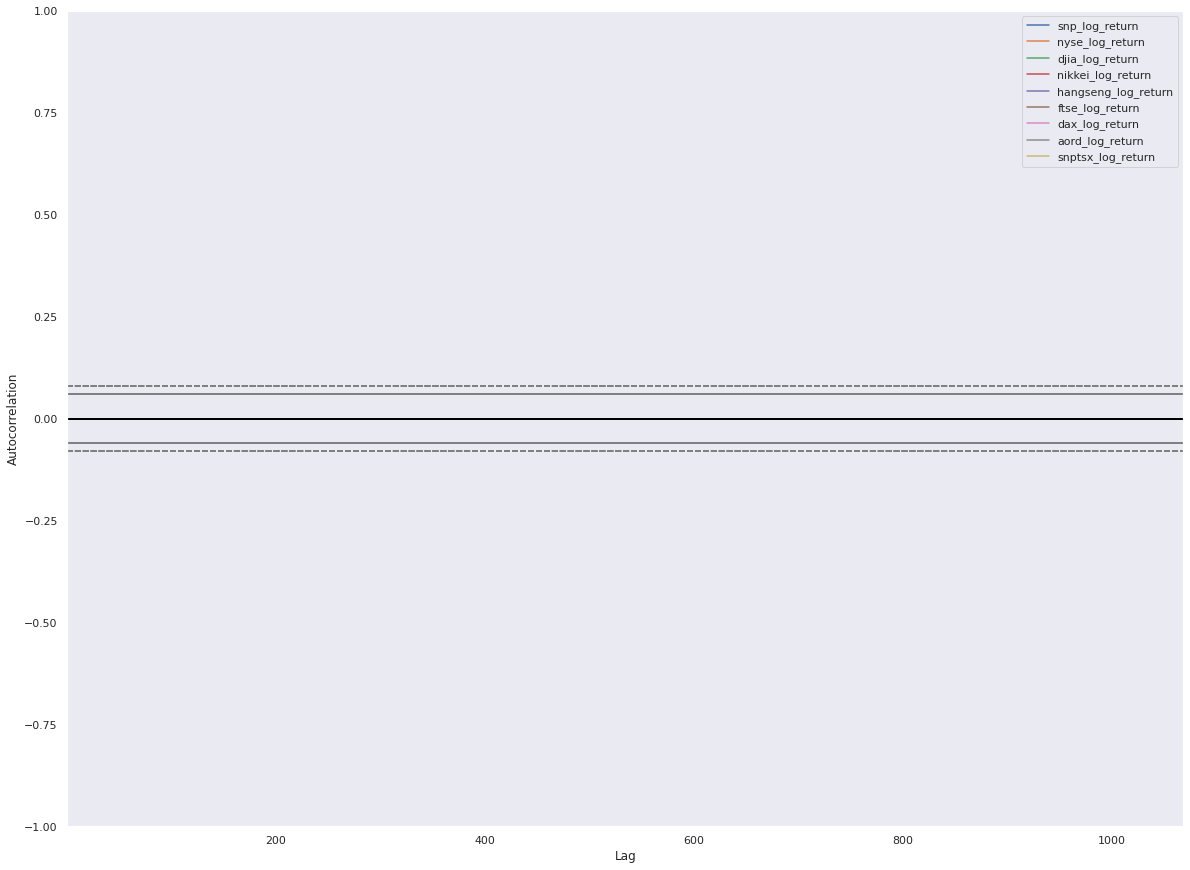

In [19]:
_ = autocorrelation_plot(log_return_data['snp_log_return'], label='snp_log_return')
_ = autocorrelation_plot(log_return_data['nyse_log_return'], label='nyse_log_return')
_ = autocorrelation_plot(log_return_data['djia_log_return'], label='djia_log_return')
_ = autocorrelation_plot(log_return_data['nikkei_log_return'], label='nikkei_log_return')
_ = autocorrelation_plot(log_return_data['hangseng_log_return'], label='hangseng_log_return')
_ = autocorrelation_plot(log_return_data['ftse_log_return'], label='ftse_log_return')
_ = autocorrelation_plot(log_return_data['dax_log_return'], label='dax_log_return')
_ = autocorrelation_plot(log_return_data['aord_log_return'], label='aord_log_return')
_ = autocorrelation_plot(log_return_data['snptsx_log_return'], label='snptsx_log_return')

_ = plt.legend(loc='upper right')

No autocorrelations are visible in the plot, which is what we're looking for. Individual financial markets are Markov processes, knowledge of history doesn't allow you to predict the future. 

You now have time series for the indices, stationary in the mean, similarly centered and scaled. That's great! Now start to look for signals to try to predict the close of the S&P/TSX Composite Index. 

Look at a scatterplot to see how the log return indices correlate with each other.

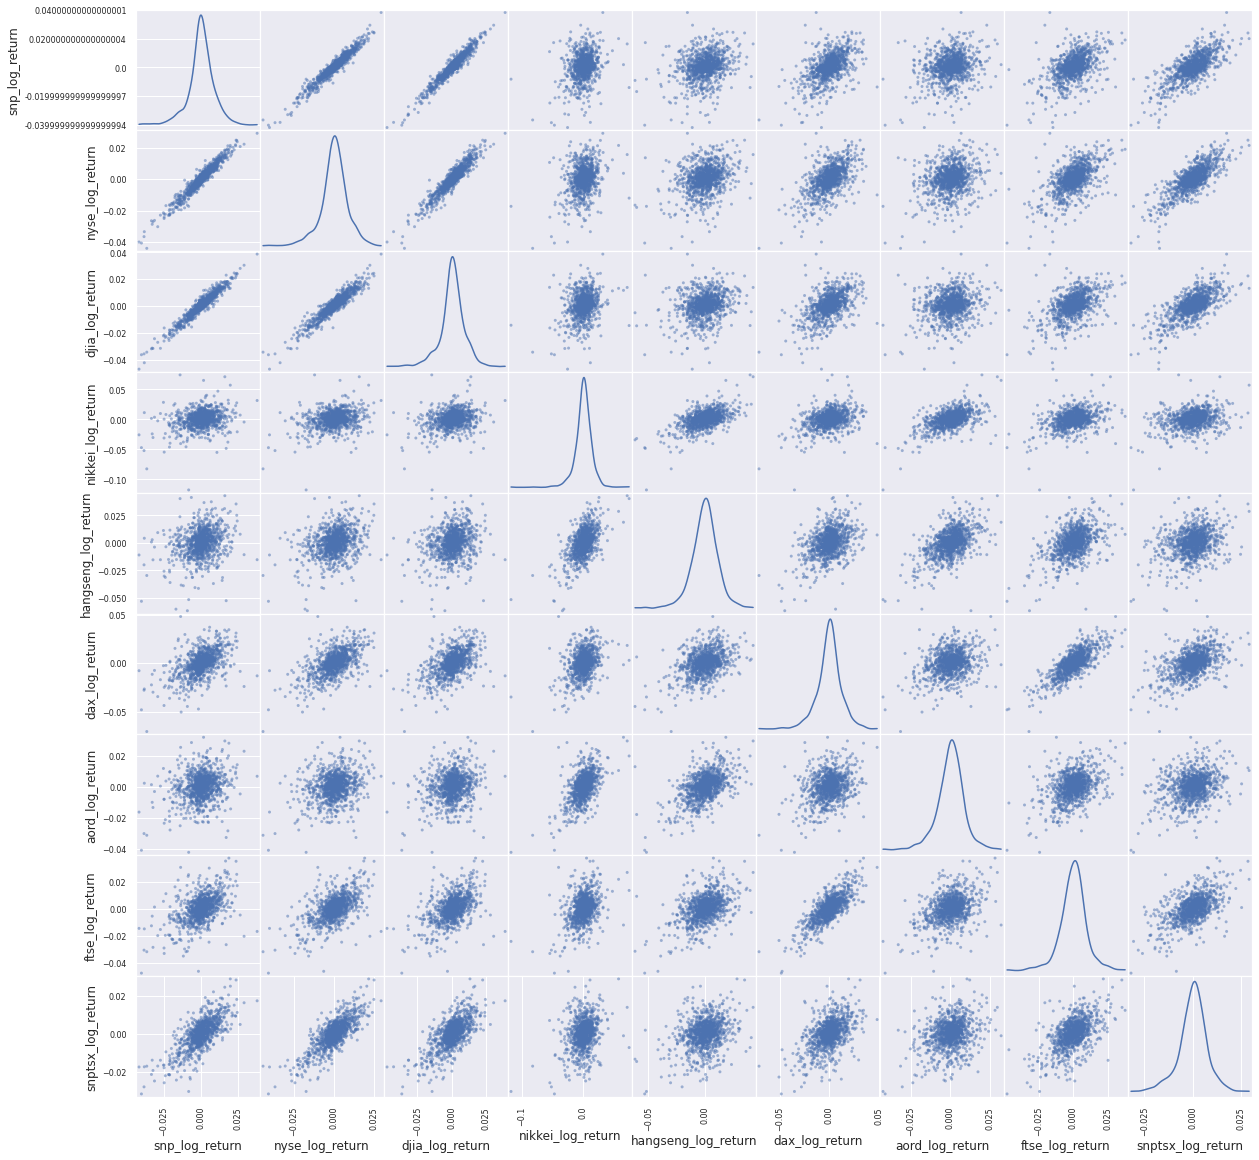

In [20]:
_ = scatter_matrix(log_return_data, figsize=(20, 20), diagonal='kde')

The story with the previous scatter plot for log returns is more subtle and more interesting. The US indices are strongly correlated, as expected. The other indices, less so, which is also expected. But there is structure and signal there. Now let's move forward and start to quantify it so we can start to choose features for our model.

First look at how the log returns for the closing value of the S&P/TSX Composite Index correlate with the closing values of other indices available on the same day. This essentially means to assume the indices that close before the S&P/TSX Composite Index are available and the others are not.

In [21]:
tmp = pd.DataFrame()
tmp['snptsx_1'] = log_return_data['snptsx_log_return']
tmp['snp_1'] = log_return_data['snp_log_return']
tmp['nyse_1'] = log_return_data['nyse_log_return'].shift()
tmp['djia_1'] = log_return_data['djia_log_return'].shift()
tmp['ftse_0'] = log_return_data['ftse_log_return']
tmp['dax_0'] = log_return_data['dax_log_return']
tmp['hangseng_0'] = log_return_data['hangseng_log_return']
tmp['nikkei_0'] = log_return_data['nikkei_log_return']
tmp['aord_0'] = log_return_data['aord_log_return']
tmp.corr().iloc[:,0]

snptsx_1      1.000000
snp_1         0.730205
nyse_1        0.065554
djia_1        0.054100
ftse_0        0.551651
dax_0         0.504182
hangseng_0    0.303480
nikkei_0      0.289502
aord_0        0.304874
Name: snptsx_1, dtype: float64

Here, we are directly working with the premise. We're correlating the close of the S&P/TSX Composite Index with signals available before the close of the S&P/TSX Composite Index.  And you can see that the S&P/TSX Composite Index close is correlated with European indices at around 0.5 for the FTSE and DAX, which is a strong correlation, and Asian/Oceanian indices at around 0.23-0.26, which is a significant correlation, but not with US indices. We have available signals from other indices and regions for our model.

Now look at how the log returns for the S&P closing values correlate with index values from the previous day to see if they previous closing is predictive. Following from the premise that financial markets are Markov processes, there should be little or no value in historical values.

In [22]:
tmp = pd.DataFrame()
tmp['snptsx_0'] = log_return_data['snptsx_log_return']
tmp['snp_1'] = log_return_data['snp_log_return'].shift(2)
tmp['nyse_1'] = log_return_data['nyse_log_return'].shift(2)
tmp['djia_1'] = log_return_data['djia_log_return'].shift(2)
tmp['ftse_0'] = log_return_data['ftse_log_return'].shift(1)
tmp['dax_0'] = log_return_data['dax_log_return'].shift(1)
tmp['hangseng_0'] = log_return_data['hangseng_log_return'].shift(1)
tmp['nikkei_0'] = log_return_data['nikkei_log_return'].shift(1)
tmp['aord_0'] = log_return_data['aord_log_return'].shift(1)
tmp.corr().iloc[:,0]

snptsx_0      1.000000
snp_1         0.001117
nyse_1       -0.003313
djia_1       -0.007218
ftse_0        0.085577
dax_0         0.089164
hangseng_0    0.044266
nikkei_0      0.020944
aord_0        0.038540
Name: snptsx_0, dtype: float64

You should see little to no correlation in this data, meaning that yesterday's values are no practical help in predicting today's close. Let's go one step further and look at correlations between today and the the day before yesterday.

In [23]:
tmp = pd.DataFrame()
tmp['snptsx_0'] = log_return_data['snptsx_log_return']
tmp['snp_1'] = log_return_data['snp_log_return'].shift(3)
tmp['nyse_1'] = log_return_data['nyse_log_return'].shift(3)
tmp['djia_1'] = log_return_data['djia_log_return'].shift(3)
tmp['ftse_0'] = log_return_data['ftse_log_return'].shift(2)
tmp['dax_0'] = log_return_data['dax_log_return'].shift(2)
tmp['hangseng_0'] = log_return_data['hangseng_log_return'].shift(2)
tmp['nikkei_0'] = log_return_data['nikkei_log_return'].shift(2)
tmp['aord_0'] = log_return_data['aord_log_return'].shift(2)

tmp.corr().iloc[:,0]

snptsx_0      1.000000
snp_1        -0.060924
nyse_1       -0.055819
djia_1       -0.055724
ftse_0       -0.023544
dax_0        -0.005632
hangseng_0   -0.015644
nikkei_0     -0.024270
aord_0       -0.011911
Name: snptsx_0, dtype: float64

Again, there are little to no correlations.

In [24]:
del tmp, closing_data, closing_data_scaled

### Summing up the EDA

At this point, you've done a good enough job of exploratory data analysis. You've visualized our data and come to know it better. You've transformed it into a form that is useful for modelling, log returns, and looked at how indices relate to each other. You've seen that indices from Europe strongly correlate with US indices, and that indices from Asia/Oceania significantly correlate with those same indices for a given day. You've also seen that if you look at historical values, they do not correlate with today's values. Summing up:

* European indices from the same day were a strong predictor for the S&P/TSX Composite Index close.
* Asian/Oceanian indices from the same day were a significant predictor for the S&P/TSX Composite Index close.
* Indices from previous days were not good predictors for the S&P/TSX Composite Index close.

## 6. Feature Engineering

At this point, we can see a model:

* We'll predict whether the S&P/TSX Composite Index close today will be higher or lower than yesterday.
* We'll use all our data sources: NYSE, DJIA, Nikkei, Hang Seng, FTSE, DAX, AORD.
* We'll use three sets of data points—T, T-1, and T-2—where we take the data available on day T or T-n, meaning today's non-US data and yesterday's US data.

Predicting whether the log return of the S&P/TSX Composite Index is positive or negative is a classification problem. That is, we want to choose one option from a finite set of options, in this case positive or negative. This is the base case of classification where we have only two values to choose from, known as binary classification, or logistic regression.

This uses the findings from of our exploratory data analysis, namely that log returns from other regions on a given day are strongly correlated with the log return of the S&P/TSX Composite Index, and there are stronger correlations from those regions that are geographically closer with respect to time zones. However, our models also use data outside of those findings. For example, we use data from the past few days in addition to today.  There are two reasons for using this additional data. First, we're adding additional features to our model for the purpose of this solution to see how things perform. which is not a good reason to add features outside of a tutorial setting. Second, machine learning models are very good at finding weak signals from data.

From a training and testing perspective, time series data is easy. Training data should come from events that happened before test data events, and be contiguous in time.  Otherwise,  your model would be trained on events from "the future", at least as compared to the test data. It would then likely perform badly in practice, because you can’t really have access to data from the future. That means random sampling or cross validation don't apply to time series data. Decide on a training-versus-testing split, and divide your data into training and test datasets.

In this case, you'll create the features together with the following response column(s):

*  snptsx_log_return_positive, which is 1 if the log return of the S&P/TSX close is positive, and 0 otherwise. 

In [25]:
log_return_data['snptsx_log_return_positive'] = 0
log_return_data.loc[log_return_data['snptsx_log_return'] >= 0, 'snptsx_log_return_positive'] = 1

In [26]:
training_test_data = pd.DataFrame(
  columns=[
    'snptsx_log_return_positive',
    'snptsx_log_return_1','snptsx_log_return_2','snptsx_log_return_3',
    'snp_log_return_1', 'snp_log_return_2', 'snp_log_return_3',
    'nyse_log_return_1', 'nyse_log_return_2', 'nyse_log_return_3',
    'djia_log_return_1', 'djia_log_return_2', 'djia_log_return_3',
    'nikkei_log_return_0', 'nikkei_log_return_1', 'nikkei_log_return_2',
    'hangseng_log_return_0', 'hangseng_log_return_1', 'hangseng_log_return_2',
    'ftse_log_return_0', 'ftse_log_return_1', 'ftse_log_return_2',
    'dax_log_return_0', 'dax_log_return_1', 'dax_log_return_2',
    'aord_log_return_0', 'aord_log_return_1', 'aord_log_return_2'])

for i in range(7, len(log_return_data)):   
    training_test_data = training_test_data.append(
        {'snptsx_log_return_positive': log_return_data['snptsx_log_return_positive'].iloc[i],
        'snptsx_log_return_1':log_return_data['snptsx_log_return'].iloc[i-1],
        'snptsx_log_return_2':log_return_data['snptsx_log_return'].iloc[i-2],
        'snptsx_log_return_3':log_return_data['snptsx_log_return'].iloc[i-3],
        'snp_log_return_1':log_return_data['snp_log_return'].iloc[i-1],
        'snp_log_return_2':log_return_data['snp_log_return'].iloc[i-2],
        'snp_log_return_3':log_return_data['snp_log_return'].iloc[i-3],
        'nyse_log_return_1':log_return_data['nyse_log_return'].iloc[i-1],
        'nyse_log_return_2':log_return_data['nyse_log_return'].iloc[i-2],
        'nyse_log_return_3':log_return_data['nyse_log_return'].iloc[i-3],
        'djia_log_return_1':log_return_data['djia_log_return'].iloc[i-1],
        'djia_log_return_2':log_return_data['djia_log_return'].iloc[i-2],
        'djia_log_return_3':log_return_data['djia_log_return'].iloc[i-3],
        'nikkei_log_return_0':log_return_data['nikkei_log_return'].iloc[i],
        'nikkei_log_return_1':log_return_data['nikkei_log_return'].iloc[i-1],
        'nikkei_log_return_2':log_return_data['nikkei_log_return'].iloc[i-2],
        'hangseng_log_return_0':log_return_data['hangseng_log_return'].iloc[i],
        'hangseng_log_return_1':log_return_data['hangseng_log_return'].iloc[i-1],
        'hangseng_log_return_2':log_return_data['hangseng_log_return'].iloc[i-2],
        'ftse_log_return_0':log_return_data['ftse_log_return'].iloc[i],
        'ftse_log_return_1':log_return_data['ftse_log_return'].iloc[i-1],
        'ftse_log_return_2':log_return_data['ftse_log_return'].iloc[i-2],
        'dax_log_return_0':log_return_data['dax_log_return'].iloc[i],
        'dax_log_return_1':log_return_data['dax_log_return'].iloc[i-1],
        'dax_log_return_2':log_return_data['dax_log_return'].iloc[i-2],
        'aord_log_return_0':log_return_data['aord_log_return'].iloc[i],
        'aord_log_return_1':log_return_data['aord_log_return'].iloc[i-1],
        'aord_log_return_2':log_return_data['aord_log_return'].iloc[i-2]},
        ignore_index=True)

In [27]:
training_test_data.describe()

,snptsx_log_return_positive,snptsx_log_return_1,snptsx_log_return_2,snptsx_log_return_3,snp_log_return_1,snp_log_return_2,snp_log_return_3,nyse_log_return_1,nyse_log_return_2,nyse_log_return_3,...,hangseng_log_return_2,ftse_log_return_0,ftse_log_return_1,ftse_log_return_2,dax_log_return_0,dax_log_return_1,dax_log_return_2,aord_log_return_0,aord_log_return_1,aord_log_return_2
count,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,...,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000,1061.000000
mean,0.535344,0.000059,0.000058,0.000056,0.000388,0.000388,0.000387,0.000173,0.000173,0.000168,...,0.000103,0.000103,0.000106,0.000111,0.000216,0.000212,0.000227,0.000205,0.000205,0.000202
std,0.498984,0.007453,0.007453,0.007453,0.008799,0.008799,0.008800,0.008442,0.008442,0.008444,...,0.011838,0.009420,0.009418,0.009416,0.012117,0.012117,0.012099,0.008461,0.008461,0.008461
min,0.000000,-0.031745,-0.031745,-0.031745,-0.041843,-0.041843,-0.041843,-0.043961,-0.043961,-0.043961,...,-0.061621,-0.047795,-0.047795,-0.047795,-0.070673,-0.070673,-0.070673,-0.042477,-0.042477,-0.042477
25%,0.000000,-0.003690,-0.003690,-0.003716,-0.003043,-0.003043,-0.003051,-0.003550,-0.003550,-0.003557,...,-0.006166,-0.004682,-0.004682,-0.004680,-0.005596,-0.005596,-0.005596,-0.004059,-0.004059,-0.004059
50%,1.000000,0.000611,0.000611,0.000611,0.000530,0.000530,0.000530,0.000584,0.000584,0.000584,...,0.000700,0.000511,0.000511,0.000511,0.000805,0.000798,0.000798,0.000672,0.000672,0.000665
75%,1.000000,0.004266,0.004266,0.004266,0.004980,0.004980,0.004980,0.004761,0.004761,0.004761,...,0.006560,0.005305,0.005305,0.005305,0.006430,0.006430,0.006430,0.005046,0.005046,0.005046
max,1.000000,0.028963,0.028963,0.028963,0.038291,0.038291,0.038291,0.029209,0.029209,0.029209,...,0.042873,0.037345,0.037345,0.037345,0.048521,0.048521,0.048521,0.032049,0.032049,0.032049


In [28]:
training_test_data.columns
training_test_data.info()
training_test_data["snptsx_log_return_positive"].isnull().count()
X = training_test_data.drop('snptsx_log_return_positive',1)
y = training_test_data['snptsx_log_return_positive']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1061 entries, 0 to 1060
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   snptsx_log_return_positive  1061 non-null   float64
 1   snptsx_log_return_1         1061 non-null   float64
 2   snptsx_log_return_2         1061 non-null   float64
 3   snptsx_log_return_3         1061 non-null   float64
 4   snp_log_return_1            1061 non-null   float64
 5   snp_log_return_2            1061 non-null   float64
 6   snp_log_return_3            1061 non-null   float64
 7   nyse_log_return_1           1061 non-null   float64
 8   nyse_log_return_2           1061 non-null   float64
 9   nyse_log_return_3           1061 non-null   float64
 10  djia_log_return_1           1061 non-null   float64
 11  djia_log_return_2           1061 non-null   float64
 12  djia_log_return_3           1061 non-null   float64
 13  nikkei_log_return_0         1061 

## 7. Modelisation

### Preparation jeu donneés (Mise a l'échelle)


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X_scaler = scaler.transform(X)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaler, y, test_size=0.3, stratify=y)

###  Modèle de référence (baseline)


#### Création d'un modèle baseline et calcul de sa précision (accuracy)


In [31]:
from sklearn.dummy import DummyClassifier

baseline_clf = DummyClassifier(strategy='most_frequent') 
baseline_clf.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [32]:
from sklearn.metrics import accuracy_score

y_pred_train = baseline_clf.predict(X_train)
acc_baseline = accuracy_score(y_pred_train, y_train)
print(f'Performance du modèle de référence (dummy): {100*acc_baseline}%')

Performance du modèle de référence (dummy): 53.50404312668463%


## Recherche sur grille

### Régression logistique

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from helpers import plot_roc_curve

In [34]:
# Grid
parameters = {'C':[0.01, 0.1, 1, 10, 100],
              'l1_ratio':[0, 0.5, 1]}

# Estimator
clf_logreg = LogisticRegression(penalty='elasticnet',
                                  max_iter=10000,
                                  solver='saga')

# GridSearch avec Validation croisée
clf_logreg_grid = GridSearchCV(clf_logreg, parameters, cv=5, scoring="roc_auc", verbose=1, n_jobs=8)

In [35]:
clf_logreg_grid.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=10000, penalty='elasticnet',
                                          solver='saga'),
             n_jobs=8,
             param_grid={'C': [0.01, 0.1, 1, 10, 100], 'l1_ratio': [0, 0.5, 1]},
             scoring='roc_auc', verbose=1)

In [36]:
print(f'Meilleurs paramètres: {clf_logreg_grid.best_params_}')
print(f'Meilleur score (mean CV): {clf_logreg_grid.best_score_}')

Meilleurs paramètres: {'C': 0.1, 'l1_ratio': 1}
Meilleur score (mean CV): 0.7411415336635481


#### Vérification du meilleur score

In [37]:
cv_score = cross_val_score(clf_logreg_grid.best_estimator_, X_train, y_train, cv=5, scoring="roc_auc", verbose=1, n_jobs=8)
cv_score.mean()

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:    0.2s finished


0.7411415336635481

#### Aire sous la courbe

In [38]:
y_train_pred_proba_logreg = clf_logreg_grid.best_estimator_.predict_proba(X_train)[:,1]
print(f'AUC = {roc_auc_score(y_train, y_train_pred_proba_logreg)}')

AUC = 0.7554265688314533


#### Courbe ROC

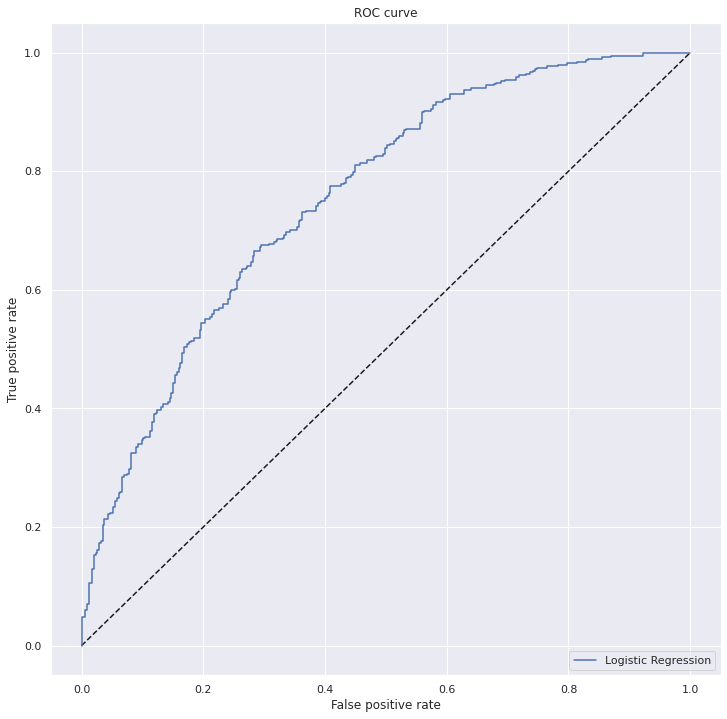

In [39]:
results = {}
results['Logistic Regression'] = y_train_pred_proba_logreg
plot_roc_curve(results, y_train)

### K plus proches voisins

In [40]:
from sklearn.neighbors import KNeighborsClassifier

In [41]:
# Grid
parameters = {
    "n_neighbors": [1,2,3,4,5, 10],
    "p": [1,2],
    "weights": ['uniform','distance'],
}

clf_knn = KNeighborsClassifier()

clf_knn_grid = GridSearchCV(clf_knn, parameters, cv=5, scoring="roc_auc", verbose=1, n_jobs=-1)
clf_knn_grid.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 10], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='roc_auc', verbose=1)

In [42]:
clf_knn_grid.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 10], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='roc_auc', verbose=1)

In [43]:
print(f'Meilleurs paramètres: {clf_knn_grid.best_params_}')
print(f'Meilleur score (mean CV): {clf_knn_grid.best_score_}')

Meilleurs paramètres: {'n_neighbors': 10, 'p': 2, 'weights': 'distance'}
Meilleur score (mean CV): 0.6918072372041827


#### Aire sous la courbe

In [44]:
y_train_pred_proba_knn = clf_knn_grid.best_estimator_.predict_proba(X_train)[:,1]
print(f'AUC = {roc_auc_score(y_train, y_train_pred_proba_knn)}')

AUC = 1.0


In [45]:
clf_knn = KNeighborsClassifier(n_neighbors=6, p=1, weights="distance").fit(X_train, y_train)
clf_knn.score(X_train, y_train)

1.0

#### Courbe ROC

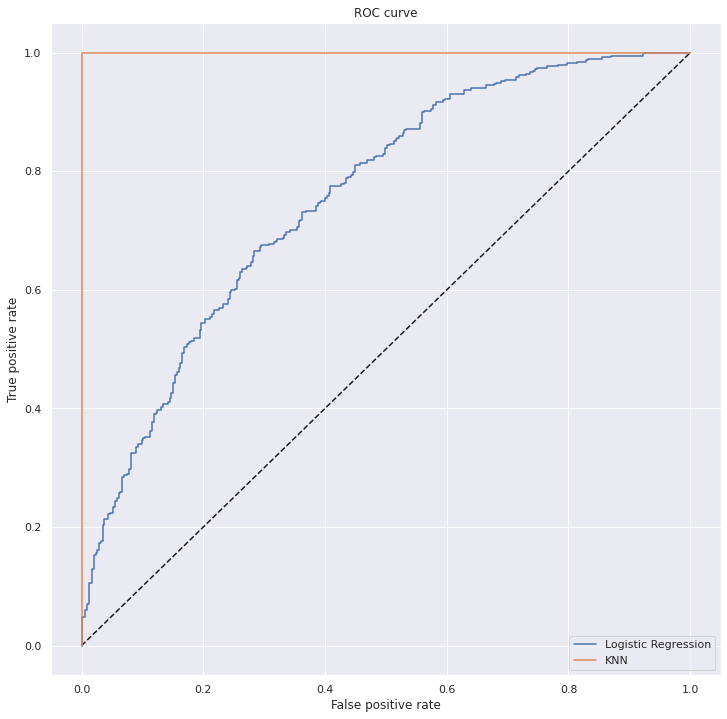

In [46]:
results['KNN'] = y_train_pred_proba_knn
plot_roc_curve(results, y_train)

## Recherche aléatoire

### Arbres de décision

In [47]:
from sklearn.utils.fixes import loguniform
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

In [48]:
# Distributions des paramètres
distributions = dict(
    criterion=['gini', 'entropy'],
    ccp_alpha=loguniform(1e-3, 1e3),
    max_depth=randint(2, 128))

# Estimateur
clf_tree = DecisionTreeClassifier()

    
# Recherche aléatoire avec avec validation croisée
clf_tree_rnd = RandomizedSearchCV(clf_tree, distributions, n_iter=1000, cv=5, scoring="roc_auc", verbose=1, n_jobs=8)

In [49]:
clf_tree_rnd.fit(X_train, y_train)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_iter=1000,
                   n_jobs=8,
                   param_distributions={'ccp_alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f7b13765970>,
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f7b13727160>},
                   random_state=2021, scoring='roc_auc', verbose=1)

In [50]:
print(f'Meilleurs paramètres: {clf_tree_rnd.best_params_}')
print(f'Meilleur score (mean CV): {clf_tree_rnd.best_score_}')

Meilleurs paramètres: {'ccp_alpha': 0.016374495969171787, 'criterion': 'entropy', 'max_depth': 29}
Meilleur score (mean CV): 0.7107934323977252


#### Aire sous la courbe

In [51]:
y_train_pred_proba_tree = clf_tree_rnd.best_estimator_.predict_proba(X_train)[:,1]
print(f'AUC = {roc_auc_score(y_train, y_train_pred_proba_tree)}')

AUC = 0.7317380352644836


#### Courbe ROC

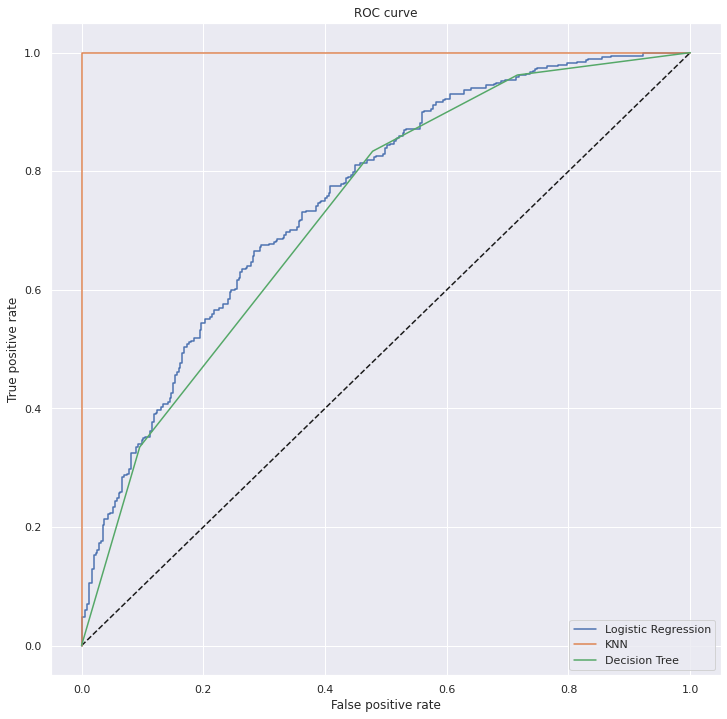

In [52]:
results['Decision Tree'] = y_train_pred_proba_tree
plot_roc_curve(results, y_train)

### Bagging

In [53]:
from sklearn.ensemble import BaggingClassifier

In [54]:
# Distributions des paramètres
distributions = dict(
    n_estimators=randint(2, 500))

# Estimateur
clf_bag = BaggingClassifier(base_estimator=clf_tree_rnd.best_estimator_)

# Recherche aléatoire avec validation croisée
clf_bag_rnd = RandomizedSearchCV(clf_bag, distributions, n_iter=100, cv=5, scoring="roc_auc", verbose=1, n_jobs=8)

In [55]:
clf_bag_rnd.fit(X_train, y_train)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.016374495969171787,
                                                                                     criterion='entropy',
                                                                                     max_depth=29),
                                               random_state=2021),
                   n_iter=100, n_jobs=8,
                   param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f7b05d25160>},
                   random_state=2020, scoring='roc_auc', verbose=1)

In [56]:
print(f'Meilleurs paramètres: {clf_bag_rnd.best_params_}')
print(f'Meilleur score (mean CV): {clf_bag_rnd.best_score_}')

Meilleurs paramètres: {'n_estimators': 486}
Meilleur score (mean CV): 0.7325605393505779


#### Aire sous la courbe

In [57]:
y_train_pred_proba_bag = clf_bag_rnd.best_estimator_.predict_proba(X_train)[:,1]
print(f'AUC = {roc_auc_score(y_train, y_train_pred_proba_bag)}')

AUC = 0.9218048406527215


#### Courbe ROC

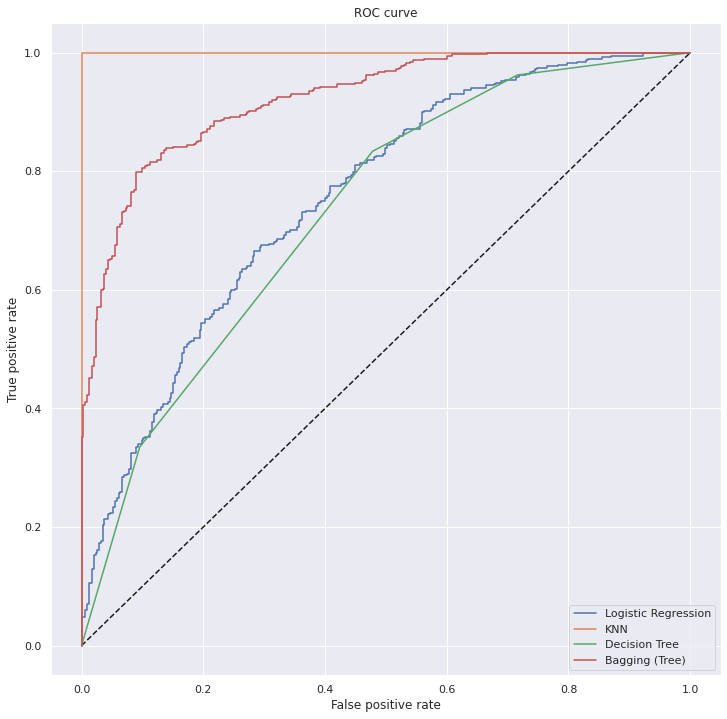

In [58]:
results['Bagging (Tree)'] = y_train_pred_proba_bag
plot_roc_curve(results, y_train)

## Hyperopt avec Forêts aléatoires et gradient boosting

In [59]:
!pip install hyperopt

In [60]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from hyperopt import hp, fmin, tpe, space_eval

### Gradient boosting

#### Définition de l'hyperespace

In [61]:
hyperspace = {
    'n_estimators': 1 + hp.randint('n_estimators', 500),
    'lr_rate': hp.loguniform('lr_rate', -8.0, 1.0),
    'max_depth': 1 + hp.randint('max_depth', 100),
    'max_features': hp.choice('max_features', ['sqrt', 'log2', None]),
    'loss': hp.choice('loss', ['deviance', 'exponential']),
    'ccp_alpha': hp.loguniform('ccp_alpha', -6, 2),
}

#### Fonction objective

In [62]:
def objective(hyperspace):

    lr = hyperspace['lr_rate']
    md = hyperspace['max_depth']
    n = hyperspace['n_estimators']
    l = hyperspace['loss']
    mf = hyperspace['max_features']
    a = hyperspace['ccp_alpha']

    clf_gb = GradientBoostingClassifier(loss=l, max_features=mf,
                                                n_estimators=n, learning_rate=lr, max_depth=md,
                                                ccp_alpha=a
                                                )
    clf_gb.fit(X_train, y_train)
    cv_score = cross_val_score(clf_gb, X_train, y_train, cv=5, scoring="roc_auc", verbose=0, n_jobs=8)

    return -cv_score.mean()

#### Lancement de l'optimisation


In [63]:
best = fmin(objective, hyperspace, algo=tpe.suggest, max_evals=100)

100%|██████████| 100/100 [08:06<00:00,  4.86s/trial, best loss: -0.7319647771051183]


#### Meilleurs paramètres

#### Réentraînement du gradient boosting avec les meilleurs hyperparamètres

In [64]:
clf_hp_gb = GradientBoostingClassifier(loss='exponential', max_features='log2',
                                                n_estimators=350, learning_rate=0.04699952299114128, max_depth=22,
                                                ccp_alpha=0.003263593371701917
                                                )
clf_hp_gb.fit(X_train, y_train)
cv_score = cross_val_score(clf_hp_gb, X_train, y_train, cv=5, scoring="roc_auc", verbose=0, n_jobs=8)
cv_score.mean()

0.7195913593835994

#### Aire sous la courbe

In [65]:
y_train_pred_proba_gb = clf_hp_gb.predict_proba(X_train)[:,1]
print(f'AUC = {roc_auc_score(y_train, y_train_pred_proba_gb)}')

AUC = 0.9981163070857518


#### Courbe ROC

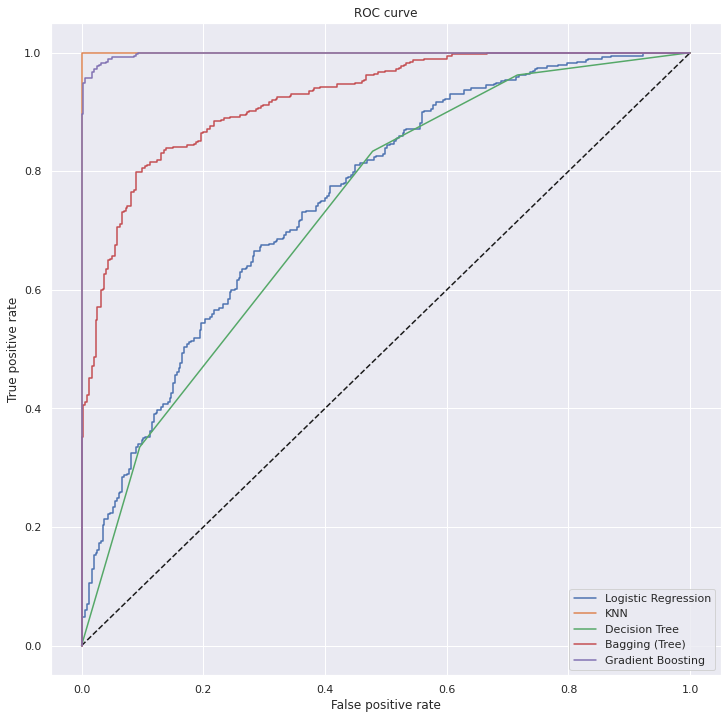

In [66]:
results['Gradient Boosting'] = y_train_pred_proba_gb
plot_roc_curve(results, y_train)

### Gradient boosting et forêts aléatoires

In [67]:
# Définition de l'hyperespace

hyperspace = hp.choice('classifier',[
    {
        'type': 'gradient-boosting',
        'n_estimators': 1 + hp.randint('n_estimators_1', 100),
        'lr_rate': hp.loguniform('lr_rate', -8, 1),
        'max_depth': 1 + hp.randint('max_depth', 100),
        'max_features': hp.choice('max_features1', ['sqrt', 'log2', None]),
        'loss': hp.choice('loss', ['deviance', 'exponential']),
        'ccp_alpha': hp.loguniform('ccp_alpha1', -6, 2)
    },
    {
        'type': 'random-forests',
        'criterion': hp.choice('criterion', ['gini', 'entropy']),
        'n_estimators': 1 + hp.randint('n_estimators_2', 500),
        'max_features': hp.choice('max_features2', ['sqrt', 'log2', None]),
        'ccp_alpha': hp.loguniform('ccp_alpha2', -6, 2)
    }
])

# Fonction objective

def objective(hyperspace):

    if hyperspace['type'] == 'gradient-boosting':
        lr = hyperspace['lr_rate']
        md = hyperspace['max_depth']
        n = hyperspace['n_estimators']
        l = hyperspace['loss']
        mf = hyperspace['max_features']
        a = hyperspace['ccp_alpha']

        clf_gb = GradientBoostingClassifier(loss=l, max_features=mf,
                                            n_estimators=n, learning_rate=lr, max_depth=md,
                                            ccp_alpha=a
                                            )
        clf_gb.fit(X_train, y_train)
        cv_score = cross_val_score(clf_gb, X_train, y_train, cv=5, scoring="roc_auc", verbose=0, n_jobs=8)

        return -cv_score.mean()
    elif hyperspace['type'] == 'random-forests':
        c = hyperspace['criterion']
        n = hyperspace['n_estimators']
        mf = hyperspace['max_features']
        a = hyperspace['ccp_alpha']
        
        clf_rf = RandomForestClassifier(criterion=c, n_estimators=n, max_features=mf, ccp_alpha=a,
                                        n_jobs=8)
        clf_rf.fit(X_train, y_train)
        cv_score = cross_val_score(clf_rf, X_train, y_train, cv=5, scoring="roc_auc", verbose=0, n_jobs=8)

        return -cv_score.mean()
    else:
        print("Error")
        return None

# Lancement de l'optimisation

best = fmin(objective, hyperspace, algo=tpe.suggest, max_evals=100)
best

100%|██████████| 100/100 [08:03<00:00,  4.83s/trial, best loss: -0.7378820399926619]


{'ccp_alpha2': 0.006042368158159781,
 'classifier': 1,
 'criterion': 1,
 'max_features2': 0,
 'n_estimators_2': 295}

## Performances sur le jeu de test

#### Aire sous la courbe

In [68]:
y_test_pred_proba_gb = clf_hp_gb.predict_proba(X_test)[:,1]
print(f'AUC = {roc_auc_score(y_test, y_test_pred_proba_gb)}')

AUC = 0.7218270902481428


#### Courbe ROC

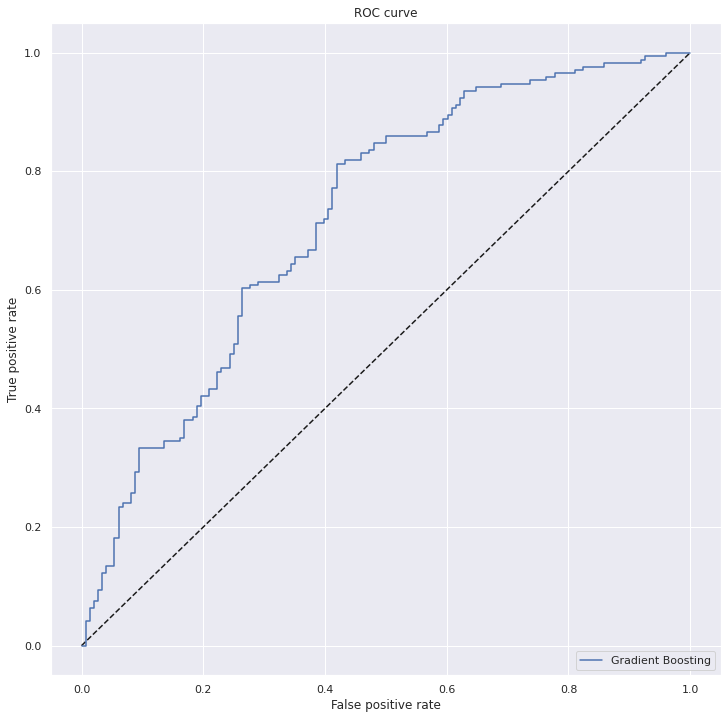

In [69]:
results_test = {}
results_test['Gradient Boosting'] = y_test_pred_proba_gb
plot_roc_curve(results_test, y_test)

## XGBoost

In [70]:
!pip install xgboost
import xgboost as xgb

#### Définition du modèle et entraînement

In [71]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                            colsample_bytree=0.3,
                            learning_rate=0.0011,
                            max_depth=3,
                            reg_alpha=0.01,
                            n_estimators=1000)
clf_xgb.fit(X_train, y_train)

[23:07:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.0011, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=2, num_parallel_tree=1, random_state=0,
              reg_alpha=0.01, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

#### Prédictions (train et test)

In [72]:
y_train_pred_proba_xgb = clf_xgb.predict_proba(X_train)[:,1]
y_test_pred_proba_xgb = clf_xgb.predict_proba(X_test)[:,1]

#### Aire sous la courbe

In [73]:
print(f'AUC Train = {roc_auc_score(y_train, y_train_pred_proba_xgb)}')
print(f'AUC test = {roc_auc_score(y_test, y_test_pred_proba_xgb)}')


AUC Train = 0.8640966670317234
AUC test = 0.7326932195353248


## LightGBM

In [74]:
!pip install lightgbm
import lightgbm as lgb

#### Définition du modèle et entraînement

In [75]:
clf_lgbm = lgb.LGBMClassifier(num_leaves=6, learning_rate=0.1, n_estimators=10000)
clf_lgbm.fit(X_train, y_train)

LGBMClassifier(n_estimators=10000, num_leaves=6)

#### Prédictions (train et test)

In [76]:
y_train_pred_proba_lgbm = clf_lgbm.predict_proba(X_train)[:,1]
y_test_pred_proba_lgbm = clf_lgbm.predict_proba(X_test)[:,1]

#### Aire sous la courbe

In [77]:
print(f'AUC Train = {roc_auc_score(y_train, y_train_pred_proba_lgbm)}')
print(f'AUC Test = {roc_auc_score(y_test, y_test_pred_proba_lgbm)}')

AUC Train = 1.0
AUC Test = 0.6841710131183815


## Évaluation des modèles

In [78]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

### Mise en oeuvre d'un classificateur à base de processus gaussiens

In [79]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import Matern

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

def plot_classifier(X_train, y_train, classifier, order=1, grid=100, xlabel=r"$x_1$", ylabel=r"$x_2$"):
    """
    Affichage des résultats de classification
    
    REMARQUE IMPORTANTE: le code ci-dessous a été écrit à l'arrache et n'est absolument pas un modèle de beau code...
    """
    
    X = X_train
    
    f, axes = plt.subplots(1,2)
    xx = np.linspace(X[:,0].min(), X[:,0].max(), grid)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), grid)
    XX, YY = np.meshgrid(xx,yy)
    
    axes[0].set_xlim(X[:,0].min(),X[:,0].max())
    axes[0].set_ylim(X[:,1].min(),X[:,1].max())
    
    vec = np.c_[XX.ravel(), YY.ravel()]
        
    z = classifier.predict_proba(vec)[:, 1]
    z = z.reshape(XX.shape)
    
    sns.scatterplot(x=X[:,0], y=X[:,1], hue=y_train.ravel(), ax=axes[0], s=50)
    CS = axes[0].contour(XX,YY,z,[0.5], colors=["g"])
    axes[0].set_xlabel(xlabel)
    axes[0].set_ylabel(ylabel)
    
    labels = ['Frontière de décision']
    for i in range(len(labels)):
        CS.collections[i].set_label(labels[i])
    axes[0].legend(loc='lower left')
    
    CS2 = axes[1].contourf(XX, YY, z, 100, cmap="inferno")
    CS = axes[1].contour(XX,YY,z,[0.5], colors=["w"])

# Distribution des parametres
parametres = {
    'kernel' : [RBF(1.0),Matern(nu=1.0)]
}

clf_gpc = GaussianProcessClassifier()
clf_gpc_grid = GridSearchCV(clf_gpc,parametres,cv=5,scoring='roc_auc',verbose = 1,n_jobs = -1)
clf_gpc_grid.fit(X_train,y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


GridSearchCV(cv=5, estimator=GaussianProcessClassifier(), n_jobs=-1,
             param_grid={'kernel': [RBF(length_scale=1),
                                    Matern(length_scale=1, nu=1)]},
             scoring='roc_auc', verbose=1)

In [80]:
print(f'Meilleurs parameters:{clf_gpc_grid.best_params_}')
print(f'Meilleurs score (mean CV):{clf_gpc_grid.best_score_}')

Meilleurs parameters:{'kernel': Matern(length_scale=1, nu=1)}
Meilleurs score (mean CV):0.7267616033755274


## SVM

#### Définition du modèle et entraînement

In [81]:
from sklearn.svm import SVC
clf_svc = SVC()
clf_svc.fit(X_train,y_train)

SVC()

#### Prédictions (train et test)


In [82]:
y_train_pred_svc = clf_svc.predict(X_train)
y_test_pred_svc = clf_svc.predict(X_test)

#### Accuracy et score F1

In [83]:
from sklearn.metrics import accuracy_score, f1_score


In [84]:
print(f'F1 train :{f1_score(y_train,y_train_pred_svc)}')
print(f'F1 test :{f1_score(y_test,y_test_pred_svc)}')


F1 train :0.8107476635514019
F1 test :0.7282608695652173


In [85]:
print(f'acuracy train :{accuracy_score(y_train,y_train_pred_svc)}')
print(f'accuracy test :{accuracy_score(y_test,y_test_pred_svc)}')

acuracy train :0.7816711590296496
accuracy test :0.6865203761755486


## SVM avec GridSearchCV


In [86]:
#Grid
paramters = {
    'C':[0.01,0.1,1.0],
    'kernel':['linear','rbf','sigmoid'],
    'gamma':['scale','auto']
}

clf_scv = SVC()

#GridSearch avec validation croisee
clf_svc_grid = GridSearchCV(clf_gpc,parametres,cv=5,scoring='f1',verbose = 1,n_jobs = -1)
clf_svc_grid.fit(X_train,y_train)


Fitting 5 folds for each of 2 candidates, totalling 10 fits


GridSearchCV(cv=5, estimator=GaussianProcessClassifier(), n_jobs=-1,
             param_grid={'kernel': [RBF(length_scale=1),
                                    Matern(length_scale=1, nu=1)]},
             scoring='f1', verbose=1)

In [87]:
print(f'Meilleurs parameters:{clf_svc_grid.best_params_}')
print(f'Meilleurs score (mean CV):{clf_svc_grid.best_score_}')

Meilleurs parameters:{'kernel': RBF(length_scale=1)}
Meilleurs score (mean CV):0.704933745109408


#### Prédictions (train et test)

In [88]:
y_train_pred_svc = clf_svc_grid.predict(X_train)
y_test_pred_svc = clf_svc_grid.predict(X_test)

#### Accuracy et score F1

In [89]:
print(f'F1 train :{f1_score(y_train,y_train_pred_svc)}')
print(f'F1 test :{f1_score(y_test,y_test_pred_svc)}')

F1 train :0.6971027216856892
F1 test :0.6979591836734694


## Probability=True


#### Définition du modèle et entraînement

In [90]:
clf_svc = SVC(C=0.1,kernel='linear',gamma='scale',probability=True)
clf_svc.fit(X_train,y_train)

SVC(C=0.1, kernel='linear', probability=True)

#### Prédictions (train et test)

In [91]:
y_train_pred_svc = clf_svc_grid.predict_proba(X_train)[:,1]
y_test_pred_svc = clf_svc_grid.predict_proba(X_test)[:,1]

#### ROC et AUC

In [92]:
from sklearn.metrics import roc_auc_score,roc_curve
print(f'AUC train :{roc_auc_score(y_train,y_train_pred_svc)}')
print(f'AUC test :{roc_auc_score(y_test,y_test_pred_svc)}')

AUC train :0.7263315445551783
AUC test :0.765647226173542


## VotingClassifier

### Regression losistique avec GridSearchCV

In [98]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import ElasticNet


In [101]:
parameters = {'C':[1, 2, 3],
              'l1_ratio':[0, 0.5, 1]}

# Régression logistique
clf_logreg = LogisticRegression(penalty='elasticnet',
                                max_iter=10000,
                                solver='saga',
                                n_jobs=-1)



# GridSearch avec Validation croisée
clf_logreg_grid = GridSearchCV(clf_logreg,
                               parameters,
                               cv=5,
                               scoring="roc_auc",
                               verbose=1, n_jobs=-1).fit(X_train, y_train)


Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [102]:
clf_logreg_grid.best_score_

0.7230145844799118

In [103]:
history = {}
history['logReg'] = {'CV':clf_logreg_grid.best_score_}
history['logReg']['CV']

0.7230145844799118

### Arbre de décision avec GridSearchCV

In [105]:
# Distributions des paramètres
distributions = dict(
    criterion=['gini', 'entropy'],
    ccp_alpha=loguniform(1e-3, 1e3),
    max_depth=randint(2, 128))

# Estimateur
clf_tree = DecisionTreeClassifier(random_state=2021)
   
# Recherche aléatoire avec avec validation croisée
clf_tree_rnd = RandomizedSearchCV(clf_tree,
                                  distributions,
                                  n_iter=1000,
                                  cv=5,
                                  scoring="roc_auc",
                                  verbose=1, n_jobs=-1).fit(X_train, y_train)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


In [106]:
clf_tree_rnd.best_score_

0.7107934323977252

In [107]:
history['tree'] = {'CV':clf_tree_rnd.best_score_}
history['tree']['CV']

0.7107934323977252

In [120]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
# xgboot with grid search

# grid search
model = xgb.XGBClassifier()
n_estimators = [50, 100, 150, 200]
max_depth = [2, 4, 6, 8]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
clf_xgboot_grid = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold,
verbose=1)
clf_xgboot_grid.fit(X_train, y_train)


Fitting 10 folds for each of 16 candidates, totalling 160 fits
[02:36:44] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=7, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=Non

In [111]:
history['xgboot'] = {'CV':clf_xgboot_grid.best_score_}
history['xgboot']['CV']

-0.8006101447013059

In [112]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
clf_randforest=RandomForestClassifier()
clf_randforest_grid = GridSearchCV(estimator=clf_randforest, param_grid=param_grid, cv= 5)
clf_randforest_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 500]})

In [113]:
# summarize results
history['randforest'] = {'CV':clf_randforest_grid.best_score_}
history['randforest']['CV']
history

{'logReg': {'CV': 0.7230145844799118},
 'tree': {'CV': 0.7107934323977252},
 'xgboot': {'CV': -0.8006101447013059},
 'randforest': {'CV': 0.6873118084527481}}

In [118]:
estimators = [('tree',clf_tree_rnd.best_estimator_),
              ('LogReg',clf_logreg_grid.best_estimator_),
              ('RandomForest',clf_randforest_grid.best_estimator_),
               ('knn',clf_knn_grid.best_estimator_),
              ('gpc',clf_gpc_grid.best_estimator_),
              ('xgboot',clf_xgboot_grid.best_estimator_),
              ('svc',clf_svc_grid.best_estimator_)
]

clf_vote = VotingClassifier(estimators=estimators,voting='soft',n_jobs=-1)
clf_vote.fit(X_train,y_train)


VotingClassifier(estimators=[('tree',
                              DecisionTreeClassifier(ccp_alpha=0.016374495969171787,
                                                     criterion='entropy',
                                                     max_depth=29,
                                                     random_state=2021)),
                             ('LogReg',
                              LogisticRegression(C=1, l1_ratio=1,
                                                 max_iter=10000, n_jobs=-1,
                                                 penalty='elasticnet',
                                                 solver='saga')),
                             ('RandomForest',
                              RandomForestClassifier(max_depth=4,
                                                     max_features='log2',
                                                     n_estimators=200)),
                             ('knn',
                              KNe...
          

In [119]:
cv_vote = cross_val_score(clf_vote,X_train,y_train,cv=5,scoring='roc_auc',verbose=1, n_jobs=-1)
cv_vote.mean()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.4s finished


0.7360718216840947

## Conclusion

### Le model qui donne les meilleurs resultats est donc l'estimateur VotingClassifier avec score de 73.6%

### Référence (Webographie)
#### https://www.researchgate.net/publication/228289340_Predicting_Stock_Market_Indices_Movements